# Example application of the extended Kalman filter to the Van der Pol oscillator


This notebook demonstrates the application of the extended Kalman filter to the [Van der pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).


Contents:

1. 

## 1. Creating synthetic data 

We consider the following system

* States $\bold{x} = (x,y)$

* Observations $\bold{z} = z$

with 

$$\dot{x} = y + \epsilon_{\rm p}$$

$$\dot{y} = \mu(1-x^2)y - x$$

$$z = xy + \epsilon_{\rm m} $$


This is the second order Van der Pol oscillator recast as a pair of first order ODEs, with some process noise added. The observation $z$ is arbitrarily chosen to be a product of the states.

<div class="alert alert-block alert-info">
<b>Example:</b> Blue boxes are used to display information.
</div>

In [218]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

class VanDerPol:
    """ Simulates the signal from a Van der Pol oscillator with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,μ,σp,σm, x, y,seed):
    
        self.μ  = μ
        self.σp = σp 
        self.σm = σm
        self.x  = x
        self.y  = y
        self.generator = np.random.default_rng(seed)



        
    def take_a_timestep(self):
        """ Call once for each new measurement at dt time from last call.
            Uses a basic Euler method.
        """
        

        dx = self.y + self.generator.normal(0, self.σp) #add some process noise to dx
        dy = self.μ*(1-self.x**2)*self.y - self.x 

        self.x = self.x  + self.dt*dx 
        self.y = self.y  + self.dt*dy
        
        observation = self.x*self.y + self.generator.normal(0, self.σm) 

        return self.x,self.y,observation



    def integrate(self,dt,n_steps):
        """ Integrate for n_steps timesteps and return an array that holds the states and observations
        """

        self.dt = dt
        self.n_steps   = n_steps

        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        self.output_array = np.zeros((self.n_steps,3)) 

        for i in range(self.n_steps):
            self.output_array[i,:] = VDP.take_a_timestep()



    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 8,8
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.output_array[:,0]
        y = self.output_array[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel('x', fontsize=fs)
        ax.set_xlabel('y', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w = 12,12
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)


        axes[0].plot(self.t,self.output_array[:,0])
        axes[1].plot(self.t,self.output_array[:,1])
        axes[2].plot(self.t,self.output_array[:,2])
        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

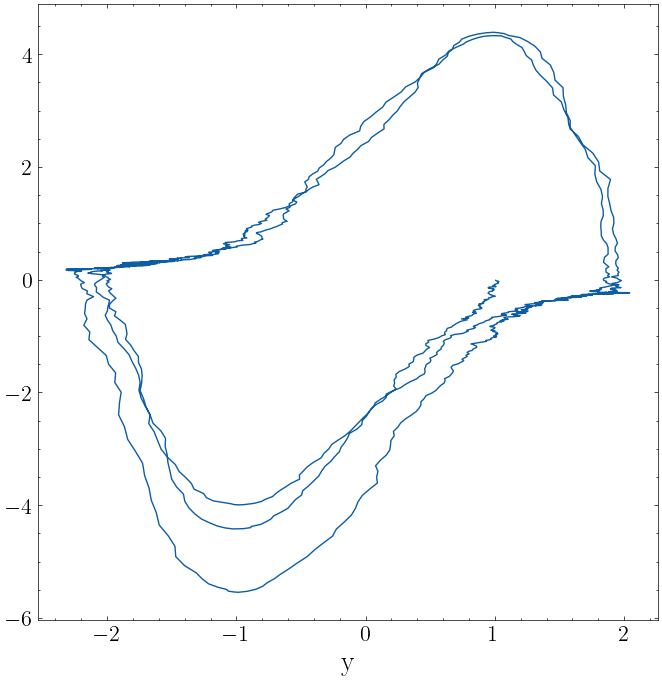

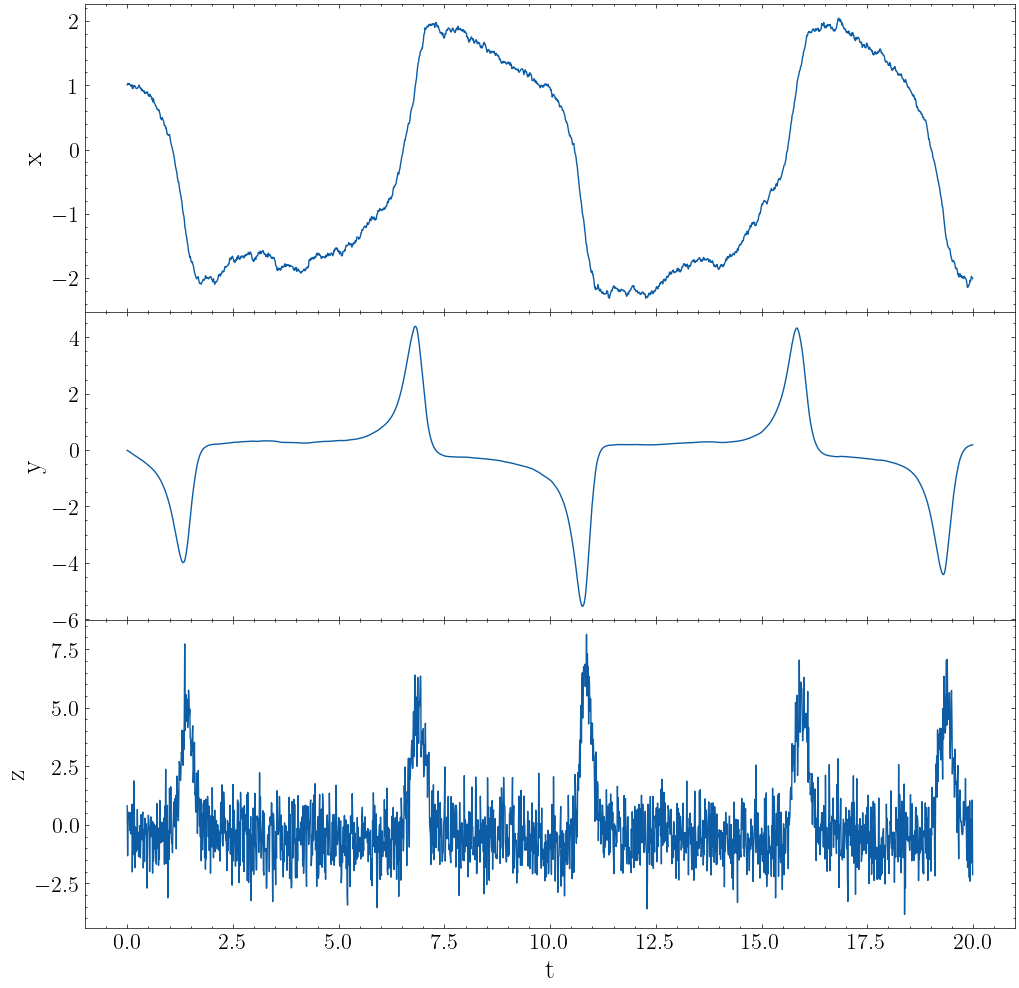

In [219]:
#Parameters of the system
μ    = 3.0
σp   = 2.0
σm   = 1.0
x0   = 1.0
y0   = .0
seed = 1

#Initialise the class
VDP = VanDerPol(μ,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

We can also turn off the process noise, e.g. 

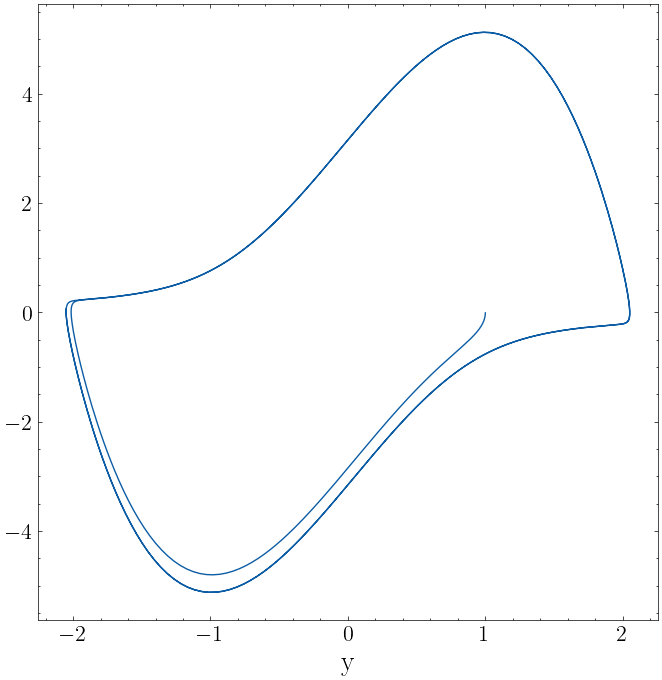

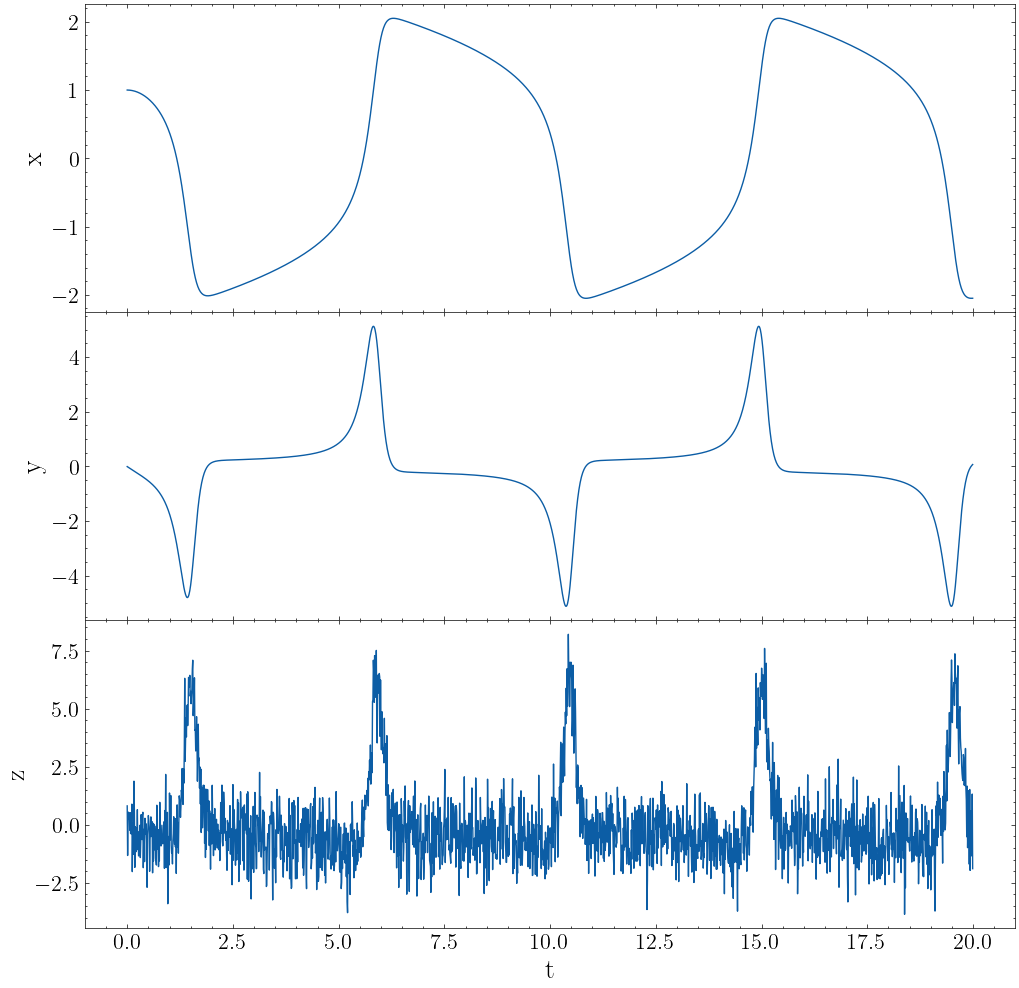

In [220]:
#Initialise the class
VDP = VanDerPol(μ,0.0,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

...and vary the damping constant 

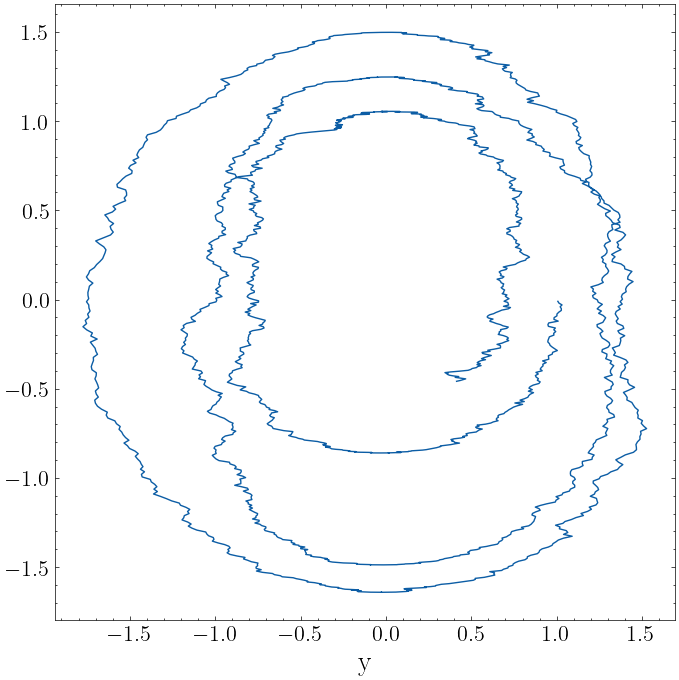

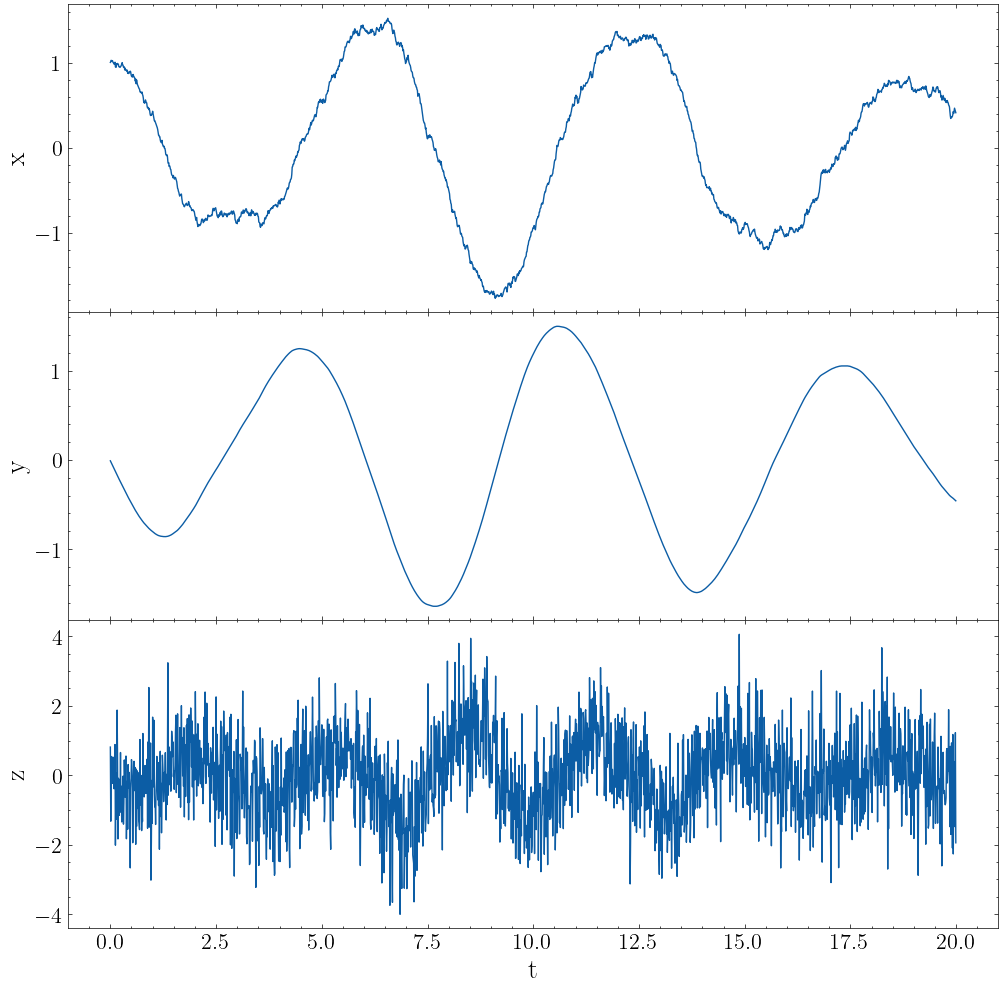

In [221]:
#Initialise the class
VDP = VanDerPol(0.01,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

## 2. Running the EKF


Given this synthetic data, lets look at how to deploy the extended Kalman filter to recover estimates of the states.

First we need to specify all the Kalman "machinery":


* States $\bold{x} = (x,y)$
* State transition function $f(\bold{x}) =\bold{x} + dt \begin{bmatrix}
           y \\
           \mu(1-x^2)y - x\\
         \end{bmatrix}$ 

* Observation function $h(\bold{x}) = xy$

* State Jacobian $F = \frac{\partial f}{\partial \boldsymbol{x}} =\begin{pmatrix}
           1 & dt \\
           -dt(2\mu x y +1) & 1+dt \mu (1-x^2)\\
         \end{pmatrix}$

* Measurement Jacobian $H = \frac{\partial h}{\partial \boldsymbol{x}} = \begin{pmatrix}
           y  \\
           x\\
         \end{pmatrix}$


* Q-matrix $\boldsymbol Q = ? (\propto \sigma_{\rm p}^2$ presumably. How does this work for non-linear systems?$) 

* R-matrix $\boldsymbol{R} = \sigma_{\rm m}^2$


